## Excersize 4, EDA, Data Pre-Processing, Feature Selection
###**Team IMDB** *Chase Hartsell, Calvin Aberg, Ben Earles*

### **Read Ins and Cleaning**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

First, we will read in the IMDB movie data from 2006-2016 and display the first few rows and some general information about the columns.

In [ ]:
imdb = pd.read_csv('/content/IMDB-Movie-Data.csv')
imdb.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [ ]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                1000 non-null   int64  
 1   Title               1000 non-null   object 
 2   Genre               1000 non-null   object 
 3   Description         1000 non-null   object 
 4   Director            1000 non-null   object 
 5   Actors              1000 non-null   object 
 6   Year                1000 non-null   int64  
 7   Runtime (Minutes)   1000 non-null   int64  
 8   Rating              1000 non-null   float64
 9   Votes               1000 non-null   int64  
 10  Revenue (Millions)  872 non-null    float64
 11  Metascore           936 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 93.9+ KB


We can see that there are not many columns with missing values, so we choose to drop these data points rather than impute their values. Additionally, we will not be using the 'Title' column as we believe, in relation to the 'Description' column, this feature does not provide much information over the other included features about the genre of the movie.

In [ ]:
# Drop rows with missing values
imdb = imdb.dropna(axis = 0)

# Drop the 'Title' column
imdb = imdb.drop(columns=['Title'])

# Reindex the data so we can interate over it more easily
imdb.reset_index(drop=True, inplace=True)

# Make a copy of the data before pre-processing
imdb_copy = imdb.copy()

In [ ]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                838 non-null    int64  
 1   Genre               838 non-null    object 
 2   Description         838 non-null    object 
 3   Director            838 non-null    object 
 4   Actors              838 non-null    object 
 5   Year                838 non-null    int64  
 6   Runtime (Minutes)   838 non-null    int64  
 7   Rating              838 non-null    float64
 8   Votes               838 non-null    int64  
 9   Revenue (Millions)  838 non-null    float64
 10  Metascore           838 non-null    float64
dtypes: float64(3), int64(4), object(4)
memory usage: 72.1+ KB


We are now left with 838 data points without any null values.

We will also break the 'Genre' column into a vector of 0s and 1s for each movie, where the length of the vector is the number of genres. If a movie falls under a given genre, then the bit in the vector for that genre is 1. Otherwise, the bit is 0. This is so we can use a multi-output classifier for when we run feature selection and go to train and test our models.

In [ ]:
# Convert the 'Genre' column into a list of genres
imdb['Genre'] = imdb['Genre'].map(lambda g: pd.Series(g.split(',')))

# Get a list of all genres in the dataset
genres = pd.Series()
for genre_list in imdb['Genre']:
  genres = np.union1d(genres, genre_list)
print('All genres:\n{}'.format(genres))

# Create new feature for multi-label output
for i in range(len(imdb)):
  genre_list = imdb['Genre'][i]

  # Create a new feature for each genre: 1 if the movie is the genre, 0 otherwise
  for genre in genre_list:
    genre_col = 'Genre_' + genre
    if genre_col not in imdb:
      imdb[genre_col] = pd.Series(np.zeros(len(imdb)))
    imdb[genre_col][i] = 1

# Drop the original column
imdb = imdb.drop(columns=['Genre'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


All genres:
['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime' 'Drama'
 'Family' 'Fantasy' 'History' 'Horror' 'Music' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Sport' 'Thriller' 'War' 'Western']


### **Feature Engineering**

In [ ]:
import re
import spacy as sp

The 'Description' feature is not very useful as it is provided. We will create a new feature for every word included in all descriptions in the data set, excluding very common words that will not provide much information about the genre. This feature will measure the frequency of a given word in the description for the movie.

In [ ]:
# Get a list of common stopwords that we want to ignore
stopwords = sp.load('en_core_web_sm').Defaults.stop_words

# Create regex for filtering out non-letters
regex = re.compile('[^a-zA-Z]+')

# Convert the 'Description' column into a list of words
imdb['Description'] = imdb['Description'].map(lambda g: pd.Series(g.split()).map(lambda s: regex.sub('', s).lower()))

# Get a list of all words in the dataset
words = []
for i in range(len(imdb)):
  word_list = imdb['Description'][i]

  # Remove non-letters and convert words to all lowercase
  word_list = word_list.map(lambda x: regex.sub('', x).lower())

  # Remove stopwords and empty strings
  word_list = [word for word in word_list if word not in stopwords and not word == '']

  # Add the new word to the list of all words
  words = np.union1d(words, word_list)

  # Create a new feature for each word, counting its frequency
  for word in word_list:
    word_freq_col = word + '_freq'
    if word + '_freq' not in imdb:
      imdb[word_freq_col] = pd.Series(np.zeros(len(imdb)))
      imdb[word_freq_col][i] = 1
    else:
      imdb[word_freq_col][i] += 1
print('All words:\n{}'.format(words))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


All words:
['aaron' 'abandoned' 'abandons' ... 'zone' 'zubrowka' 'zuckerberg']


We will perform a similar transformation with the 'Actors' feature by creating an indicator feature for each actor. This feature will be `1` if the actor is featured in the movie and `0` otherwise.


In [ ]:
# Convert the 'Actors' column into a list of words
imdb['Actors'] = imdb['Actors'].map(lambda a: pd.Series(a.split(',')).map(lambda s: s.strip()))

# Get a list of all actors in the dataset
actors = []
for i in range(len(imdb)):
  actor_list = imdb['Actors'][i]

  # Add the new actor to the list of all actors
  actors = np.union1d(actors, actor_list)

  # Create a new feature for each actor: 1 if the actor is in the movie, 0 otherwise
  for actor in actor_list:
    actor_col = 'Actor_' + actor
    if actor not in imdb:
      imdb[actor_col] = pd.Series(np.zeros(len(imdb)))
    imdb[actor_col][i] = 1
print('All actors:\n{}'.format(actors))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


All actors:
['50 Cent' 'AJ Michalka' 'Aamir Khan' ... 'Zoë Kravitz'
 'Ólafur Darri Ólafsson' 'Óscar Jaenada']


In [ ]:
# Convert 'Director' column into a dummy variable for each director
imdb = pd.get_dummies(imdb, columns=['Director'])
imdb.head()

,Rank,Description,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore,Genre_Action,...,Director_Wes Craven,Director_Whit Stillman,Director_Will Gluck,Director_William Brent Bell,Director_Woody Allen,Director_Xavier Dolan,Director_Yimou Zhang,Director_Yorgos Lanthimos,Director_Zack Snyder,Director_Zackary Adler
0,1,0 a 1 group 2 ...,0 Chris Pratt 1 Vin Diesel 2 B...,2014,121,8.1,757074,333.13,76.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,2,0 following 1 clues 2 t...,0 Noomi Rapace 1 Logan Marshall-...,2012,124,7.0,485820,126.46,65.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3,0 three 1 girls 2 ...,0 James McAvoy 1 Anya Taylor-...,2016,117,7.3,157606,138.12,62.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,0 in 1 a 2 ...,0 Matthew McConaughey 1 Reese Withersp...,2016,108,7.2,60545,270.32,59.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,5,0 a 1 secret 2 ...,0 Will Smith 1 Jared Leto 2 Mar...,2016,123,6.2,393727,325.02,40.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Drop all columns we won't be using anymore
imdb = imdb.drop(columns=['Description', 'Actors'])

### **Correlations and Distributions**


In [ ]:
import seaborn as sns

To analyze correlations and distributions, we're first going to look at the occurrences of different genres in our dataset.

In [ ]:
# Look at the occurrences of the different genres in our dataset
# list of all genres
genres = [item for sublist in [x.split(',') for x in imdb_copy['Genre']] for item in sublist] 
genre_dict = {}
for genre in set(genres):
  genre_dict[genre] = 0
# adding a count for every occurance
for genre in genres:
  genre_dict[genre] = genre_dict[genre] + 1

In [ ]:
print(set(genres))

{'War', 'Sport', 'Action', 'Mystery', 'Horror', 'Animation', 'Adventure', 'Comedy', 'History', 'Sci-Fi', 'Biography', 'Musical', 'Romance', 'Crime', 'Fantasy', 'Western', 'Drama', 'Music', 'Thriller', 'Family'}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


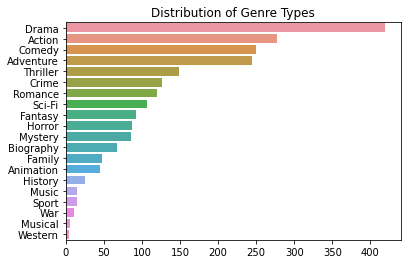

In [ ]:
genre_dict = {k: v for k, v in sorted(genre_dict.items(), key=lambda item: -1*item[1])}
x = list(genre_dict.keys())
y = list(genre_dict.values())
# plotting y vs x to flip the coordinates
_ = sns.barplot(y,x).set(title='Distribution of Genre Types')
# here we can see we have some pretty heavily seen movie genres in our data, along with several that are very rare in this dataset

In this bar plot, we can see that there are some movie genres that appear much more frequently than others (ex. Drama, Action, Comedy, Adventure) and some that are relatively very rare in our dataset (ex. Sport, War, Musical, Western).

We will look at the prevalence of the top 4 genres, since there is a fairly large gap between the number of movies with these genres and the others in the dataset.

In [ ]:
# Look at the prevelance of our top genres
top_genres = list(genre_dict.keys())[0:4]
top_sum = 0
for genre in top_genres:
  top_sum += genre_dict[genre]

print(top_sum / sum(list(genre_dict.values())))

0.54337899543379


We can see that over half of all genres mentioned in our data are the in the top 4 categories: Drama, Action, Comedy, or Adventure. To combat this, we may choose to weight our data when training our models.

Now, we will look at the most popular actors in our dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


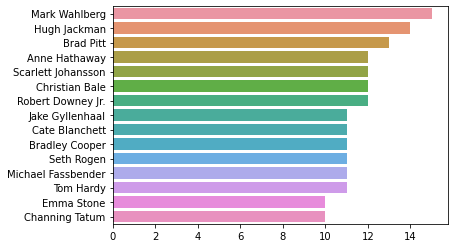

In [ ]:
# Look at our most popular actors
actors = [item.strip() for sublist in [x.split(',') for x in imdb_copy['Actors']] for item in sublist] 
actor_dict = {}
for actor in set(actors):
  actor_dict[actor] = 0
# adding for each occurance of an actor
for actor in actors:
  actor_dict[actor] = actor_dict[actor] + 1
# sorting the dictionary
actor_dict = {k: v for k, v in sorted(actor_dict.items(), key=lambda item: -1*item[1])}

x = list(actor_dict.keys())[0:15]
y = list(actor_dict.values())[0:15]
_ = sns.barplot(y,x)

In [ ]:
# we see here that there are several actors that have been in many movies, but there are no dominating actors with super high prevelance
print(actor_dict['Mark Wahlberg'] / len(actors))

0.004876462938881665


We can see that there are several actors that have been in many movies, but there are no dominating actors with high prevalence. We think that this may be an issue for including in our model, as there is likely very little predictive value: this will be explored further in feature selection

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


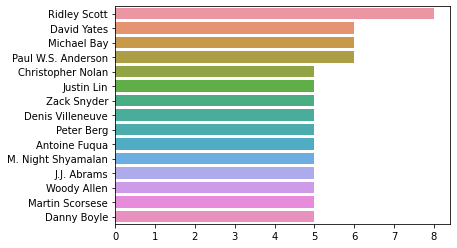

In [ ]:
# now, we'll visualize directors
directors = [item.strip() for sublist in [x.split(',') for x in imdb_copy['Director']] for item in sublist] 
director_dict = {}
for director in set(directors):
  director_dict[director] = 0
# adding for each occurance of a director
for director in directors:
  director_dict[director] = director_dict[director] + 1
# sorting the dictionary
director_dict = {k: v for k, v in sorted(director_dict.items(), key=lambda item: -1*item[1])}

x = list(director_dict.keys())[0:15]
y = list(director_dict.values())[0:15]
_ = sns.barplot(y,x)

Similar to actors, there is no meaningful cncentration of directors in this data. Similiarly, we will likely remove this feature from our data

In [ ]:
# visualize frequency of words in description
import re
# take the columns with frequency
freq_cols = [col for col in imdb.columns if re.search('freq',col)]
desc_dict = {}
# assign the word name to the sum of all occurances
for col in freq_cols:
  desc_dict[col] = sum(imdb[col])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


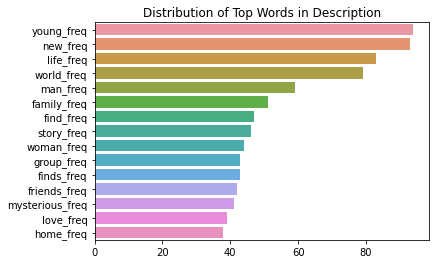

In [ ]:
# sort the dictionary
desc_dict = {k: v for k, v in sorted(desc_dict.items(), key=lambda item: -1*item[1])}

x = list(desc_dict.keys())[0:15]
y = list(desc_dict.values())[0:15]
_ = sns.barplot(y,x).set(title= "Distribution of Top Words in Description")

In [ ]:
# let's find the top words in each genre
# adding new columns for each potential genre
find_top = imdb.copy()
find_top['genre_0'] = find_top["Genre"].map(lambda x: x[0])
find_top['genre_1'] = find_top["Genre"].map(lambda x: x[1] if (len(x) > 1) else "N/A")
find_top['genre_2'] = find_top["Genre"].map(lambda x: x[2] if (len(x) > 2) else "N/A")

In [ ]:
####### this cell takes a long time to run
word_dict = {}
# for each genre in all possible genres
for genre in set(genres):
  genre_dict = {}
  # for each word in our frequency columns
  for col in freq_cols:
    # we're taking the sum of the column (word) where the genre is equal to the genre we're looking at
    # have to add genre 0 through 2 to get all possible movies with that genre
    genre_dict[col] = sum(find_top[find_top['genre_0']==genre][col])
    genre_dict[col] = genre_dict[col] + sum(find_top[find_top['genre_1']==genre][col])
    genre_dict[col] = genre_dict[col] + sum(find_top[find_top['genre_2']==genre][col])
  # assigning word dict (which has all of the genres) at genre to the dictionary of frequencies that we just made
  word_dict[genre] = genre_dict


In [ ]:
# sorting every dictionary to find the top words
for genre in word_dict.keys():
  word_dict[genre] = {k: v for k, v in sorted(word_dict[genre].items(), key=lambda item: -1*item[1])}

In [ ]:
# now, getting a dictionary of just the most common word for each genre
top_dict = {}
for genre in set(genres):
  # taking just the first word from the sorted genres
  top_word = list(word_dict[genre].keys())[0]
  top_dict[genre] = {}
  top_dict[genre][top_word] = word_dict[genre][top_word]

In [ ]:
# top words for each category
top_dict

{'Action': {'new_freq': 40.0},
 'Horror': {'young_freq': 15.0},
 'Comedy': {'life_freq': 37.0},
 'Music': {'life_freq': 4.0},
 'Romance': {'love_freq': 23.0},
 'Adventure': {'world_freq': 43.0},
 'Sci-Fi': {'world_freq': 17.0},
 'Drama': {'young_freq': 58.0},
 'Mystery': {'woman_freq': 13.0},
 'Family': {'new_freq': 9.0},
 'Crime': {'drug_freq': 12.0},
 'Western': {'help_freq': 2.0},
 'War': {'group_freq': 3.0},
 'Thriller': {'young_freq': 19.0},
 'Fantasy': {'world_freq': 19.0},
 'Animation': {'young_freq': 9.0},
 'History': {'story_freq': 6.0},
 'Sport': {'boxer_freq': 4.0},
 'Musical': {'story_freq': 2.0},
 'Biography': {'story_freq': 20.0}}

We can see here that there is a good amount of variation in the most frequent words at each genre. Of course, there are some repeats with words like "life", "young", "world", etc. that we would expect to occur in many different genres of movies. However, there are several genres with most frequent words that are very related to the actual genre like "love" for romance, or "drug" for crime, and such. This gives us a look into how our descritpion feature can be helpful in the prediction

In [ ]:
# next, we'll move to correlations of numerical variables
imdb_num = imdb_copy.select_dtypes(include = 'number').drop(columns = ['Rank','Year'])
imdb_num.head()

,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,121,8.1,757074,333.13,76.0
1,124,7.0,485820,126.46,65.0
2,117,7.3,157606,138.12,62.0
3,108,7.2,60545,270.32,59.0
4,123,6.2,393727,325.02,40.0


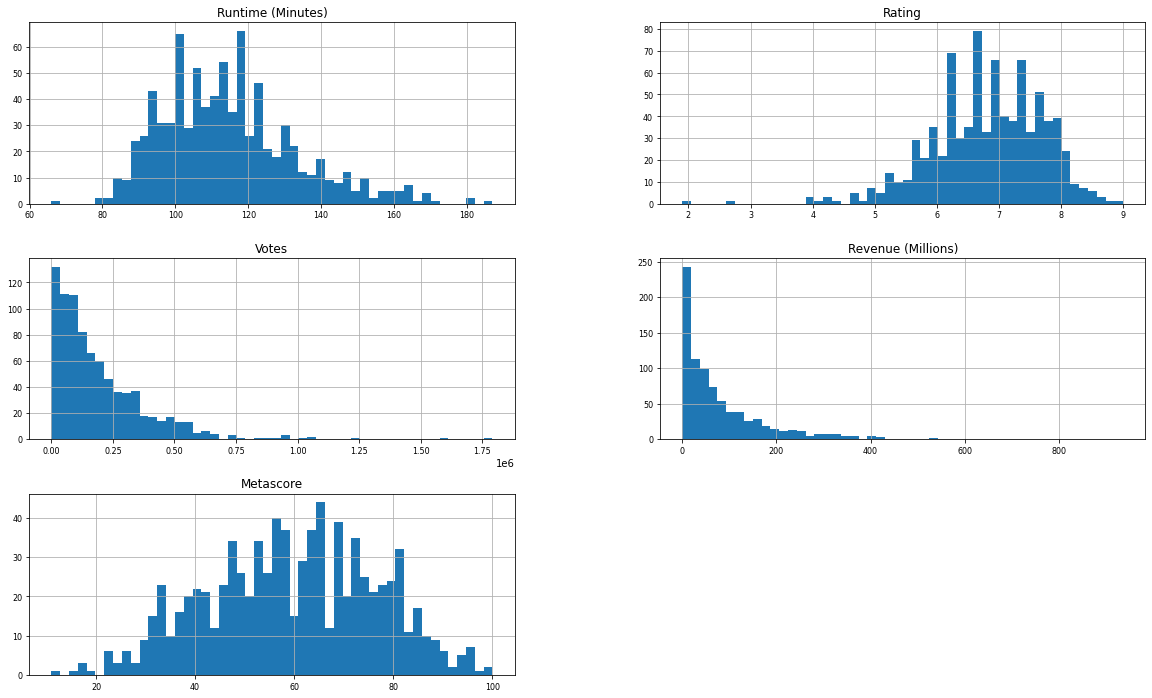

In [ ]:
# creating histograms of distributions
_ = imdb_num.hist(figsize=(20, 12), bins=50, xlabelsize=8, ylabelsize=8)

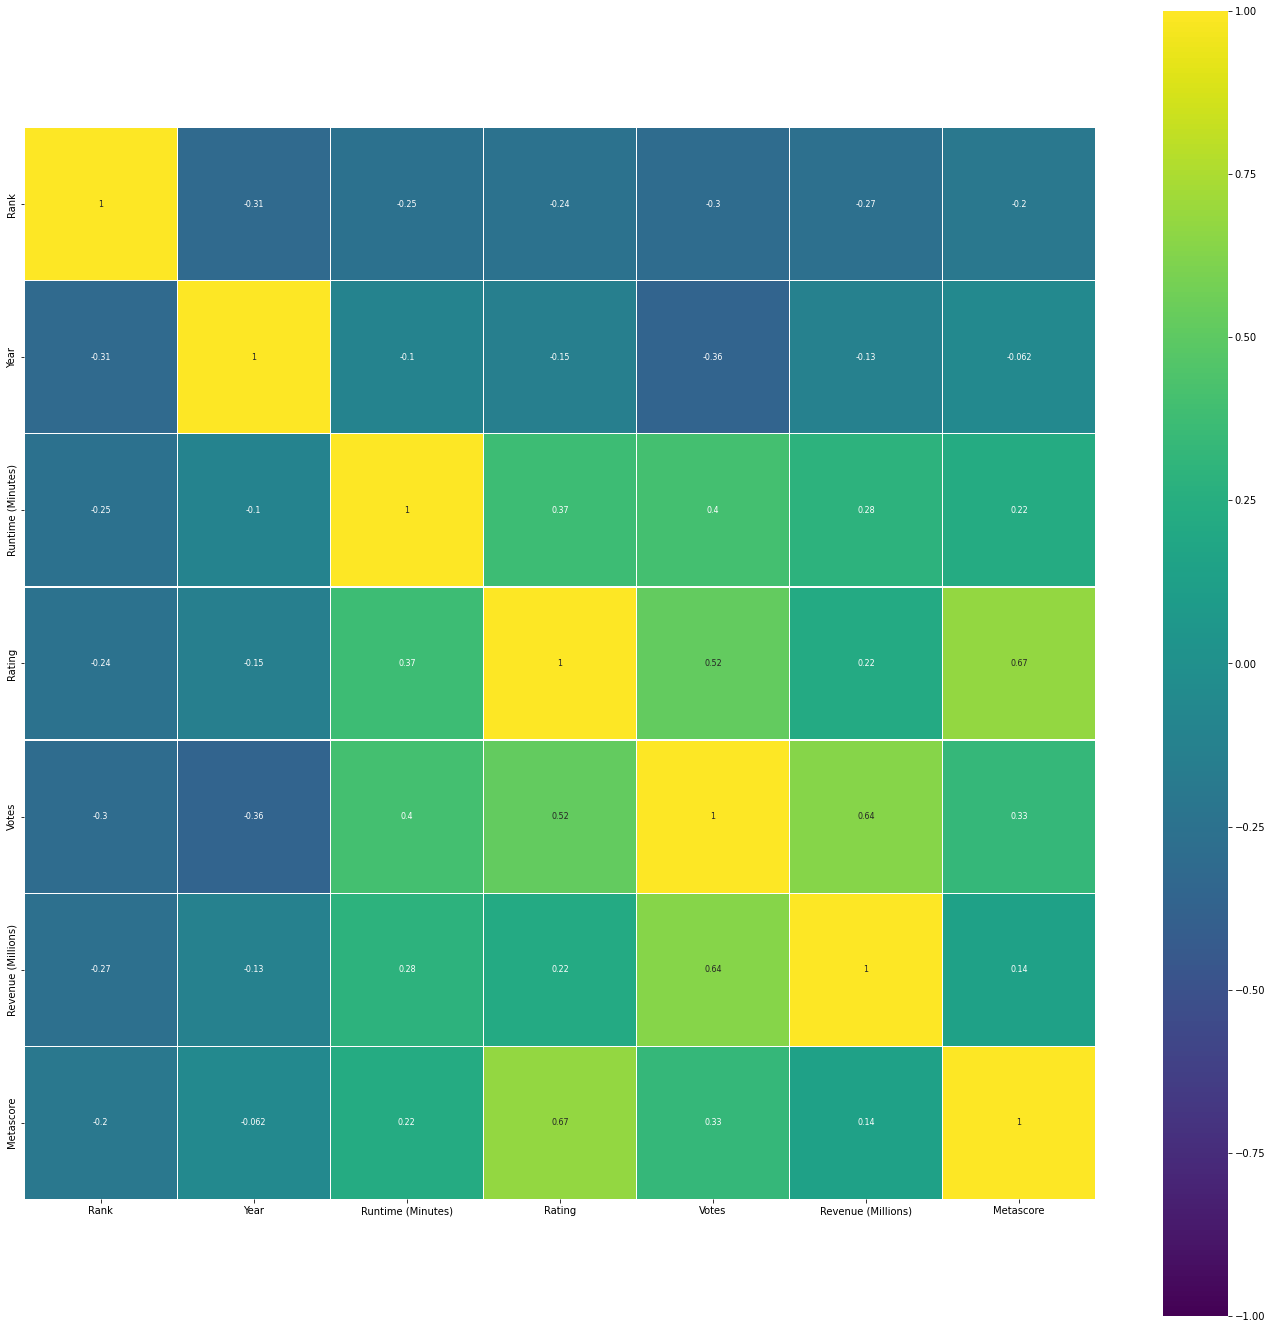

In [ ]:
# Correlation Analysis
df_corr = imdb_copy.corr()
plt.figure(figsize=(24, 24))

sns.heatmap(df_corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

We can see in the correlation heatmap that we don't have many features that are very strongly correlated with each other. However, we do have several that are higher that .5, which we will investigate more below:

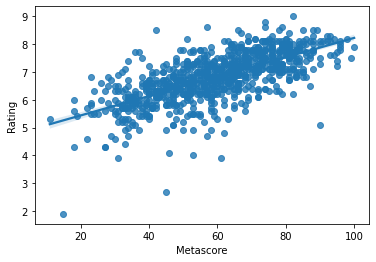

In [ ]:
# let's visualize some of the variables mith medium-high correlations
sns.regplot(data = imdb_num, x = 'Metascore',y = 'Rating')
# Metascore and Rating have very high correlation, so we'll just use one of them

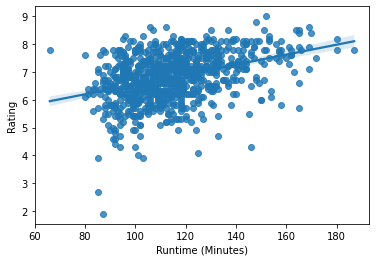

In [ ]:
sns.regplot(data = imdb_num, x = 'Runtime (Minutes)',y = 'Rating')
# Runtime vs Rating

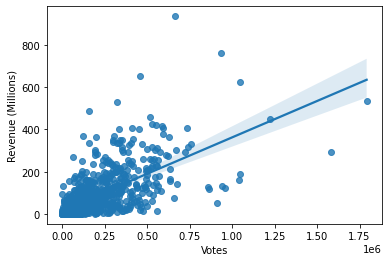

In [ ]:
sns.regplot(data = imdb_num, x = 'Votes',y = 'Revenue (Millions)')
# votes vs. revenue

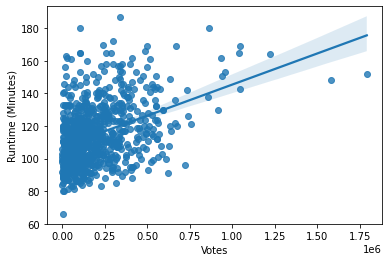

In [ ]:
sns.regplot(data = imdb_num, x = 'Votes',y = 'Runtime (Minutes)')
# votes vs. runtime

Let's check the skew of our numerical features.

In [ ]:
# Check the skew of our numerical features
from scipy.stats import skew

numeric_feats = imdb_copy.dtypes[imdb_copy.dtypes != "object"].index

skewed_feats = imdb_copy[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
Revenue (Millions),2.556027
Votes,2.462365
Runtime (Minutes),0.792025
Rank,0.061858
Metascore,-0.123981
Year,-0.585571
Rating,-0.675844


We can see that there is a very high right skew in revenue and votes, along with a moderate right skew in Runtime, and a moderate left skew in Year and Rating. If we choose to keep these features, we'll look into use a log transformation to get rid of some of the skew

To view correlations between our categorical features, we will use Cramer's V.

In [ ]:
# Keep only the top actors and directors, as otherwise this would be very difficult to interpret
print('Features before dropping:', len(imdb.columns))
top_actors = np.percentile(list(actor_dict.values()), 99.7)
imdb = imdb.drop(columns=['Actor_' + actor for actor in actor_dict.keys() if actor_dict[actor] < top_actors])
top_directors = np.percentile(list(director_dict.values()), 99.7)
imdb = imdb.drop(columns=['Director_' + director for director in director_dict.keys() if director_dict[director] < top_directors])
print('Features after dropping:', len(imdb.columns))

Features before dropping: 2189
Features after dropping: 38


In [ ]:
from scipy.stats import chi2_contingency

# Cramer's V function
# from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9 (suggested on Piazza)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Build the matrix
cols = [col for col in imdb.columns if '_freq' not in col]
cv_mat = []
for i in range(len(cols)):
  cv_row = np.zeros(len(cols))
  for j in range(i + 1):
    cv_row[j] = cramers_v(imdb[cols[i]], imdb[cols[j]])
  cv_mat.append(cv_row)

cv_df = pd.DataFrame(cv_mat, columns=[cols], index=[cols])

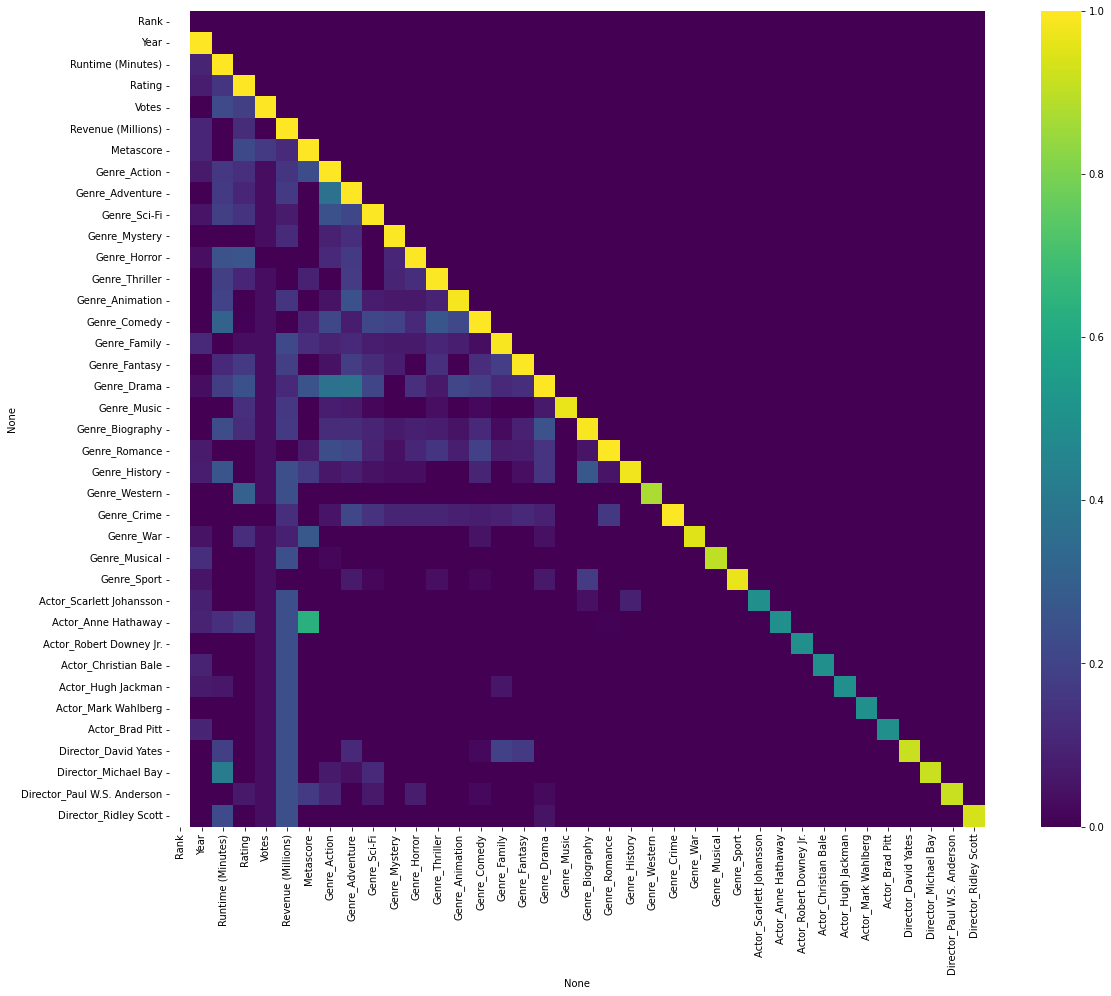

In [ ]:
# Plot a heatmap of the correlations
plt.subplots(figsize=(20, 15))
sns.heatmap(cv_df, vmin=0, vmax=1, square=True,
            cmap='viridis')

As we can see from the Cramer's V matrix, none of the top actors or directors are particularly strongly correlated with any of the genres. Moreso, some actors are correlated with appearing in movies with other actors, or even with other features such as revenue. Thus, it probably will not be necessary to include actors or directors in our training data.

### **Feature Selection**

On an intial pass, the clearest feature to remove is Rating. The feature is highly correlated with Metascore, which has a greater variation than rating. Additionally, revenue will likely be a feature we want to remove. There is a feature with medium correlation with it (votes), and revenue has an extremely skewed distribution. Additionally, the actors and directors appear with such low frequency that it would be best to leave them out.

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_multilabel_classification

moc = MultiOutputClassifier(LogisticRegression())
X=imdb.copy().drop(columns=["genre_"+genre for genre in genres])
X=X.drop(columns=['Description', 'Actors', 'Genre'])
X = X[X.columns.drop(list(X.filter(regex='Director_')))]
X = X[X.columns.drop(list(X.filter(regex='Actor_')))]
X = X[X.columns.drop(list(X.filter(regex='_freq')))]
print(X.columns)
y = imdb[["genre_"+genre for genre in genres]]
sfs1 = SequentialFeatureSelector(moc, n_features_to_select=1)
sfs2 = SequentialFeatureSelector(moc, n_features_to_select=2)
sfs3 = SequentialFeatureSelector(moc, n_features_to_select=3)
sfs4 = SequentialFeatureSelector(moc, n_features_to_select=4)
sfs5 = SequentialFeatureSelector(moc, n_features_to_select=5)
sfs1.fit(X, y)
print(sfs1.get_support())
sfs2.fit(X, y)
print(sfs2.get_support())
sfs3.fit(X, y)
print(sfs3.get_support())
sfs4.fit(X, y)
print(sfs4.get_support())

Index(['Rank', 'Year', 'Runtime (Minutes)', 'Rating', 'Votes',
       'Revenue (Millions)', 'Metascore'],
      dtype='object')
[False False False False False  True False]
[ True False False False False  True False]
[ True  True False False False  True False]
[ True  True False False  True  True False]


After running a forward sequential feature selection, Revenue turns out to be the best predictor of genre out of the numeric features, so we will want to include it. Rating and metascore are both not in the top 4 features, so there doesn't appear to be any issue with removing Rating from the feature set.

As it currently stands, actors, directors, and ratings will be the removed features.

In [ ]:
imdb = imdb.drop(columns=['Rating'])

In [ ]:
# Generate a CSV with our transformed data after EDA
imdb.to_csv('imdb-transformed.csv', index=False)